In [1]:
!pip3 install beautifulsoup4 --user
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install pyproj==1.9.6 --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [2]:
import os
import re
import multiprocessing
import datetime
from datetime import date, timedelta

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

In [3]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(["script", "style"]):
            script.extract()
        return soup
    except Exception:
        return None

def get_stations_noaa():
    soup = fetch('https://tgftp.nws.noaa.gov/data/observations/metar/stations/')
    stations = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if 'TXT' in href:
            stations.append(href.split('.TXT')[0])
    return stations

def get_stations_with_coords():
    soup = fetch('http://weather.rap.ucar.edu/surface/stations.txt')
    text = soup.get_text()
    matches = re.findall(r".*([A-Z]{4}).*[\s]([\d]+\s[\d]+\w).*[\s]([\d]+\s[\d]+\w)[\s]*(\d{1,4}).*", text)
    stations = []
    for match in matches:
        stations.append({'ICAO': match[0], 'coords': "+".join(match[1:]).replace(' ', '-')})
    return stations

def gms_to_lat_lng(gms):
    comp = gms.split('-')
    if len(comp)==2:
        if 'N' in comp[1] or 'E' in comp[1]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)
        else:
            return -(int(comp[0])+(int(comp[1][:len(comp)])/60))
    elif len(comp)==3:
        if 'N' in comp[2] or 'E' in comp[2]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)+(int(comp[2][:len(comp)-1])/60)
        else:
            comp[2]='0'+comp[2][:len(comp)-1]
            return (-int(comp[0])-(int(comp[1][:len(comp)])/60)-(int(comp[2][:len(comp)-1])/3600))
    else:
        return 0

def get_all_metar_obs(station, month):
    soup = fetch(f"https://www.ogimet.com/display_metars2.php?lugar={station['ICAO']}&tipo=SA&ord=DIR&nil=NO&fmt=txt&ano=2020&mes={month}&day=1&hora=00&anof=2020&mesf={month}&dayf=30&horaf=12&minf=59&enviar=Ver")
    if soup is None:
        return []
    text = soup.get_text()
    if f"No hay METAR/SPECI de {station} en el periodo solicitado" in text:
        return []
    data = []
    text = re.sub('\s\s+', '', text)
    matches = re.findall(r"(\d+)[\s]METAR\s(.*)=", text)
    for match in matches:
        if ',' not in match:
            (lat, lng, elev) = station['coords'].split('+')
            data.append({ 'lat': gms_to_lat_lng(lat), 'lng': gms_to_lat_lng(lng), 'elev': elev, 'datetime': match[0], 'observation': match[1] })
    return data

In [4]:
noaa_stations = get_stations_with_coords()
print(len(noaa_stations))

9580


In [5]:
test_month = 9
test_station = noaa_stations[50]
print(test_station)
metar = get_all_metar_obs(test_station, test_month)

{'ICAO': 'PAEL', 'coords': '58-12N+136-21W+3'}


In [6]:
test = metar[0]
print(test['lat'], test['lng'], test['elev'])
obs = Metar.Metar(test['observation'])
print(obs.string())

58.2 -136.35 3
station: PAEL
type: routine report, cycle 1 (automatic report)
time: Thu Oct  1 00:51:00 2020
temperature: 14.0 C
dew point: 11.0 C
wind: WNW at 11 knots
visibility: 10 miles
pressure: 1008.1 mb
sky: overcast at 1200 feet
- SPBE23025KT SEA 1 SWELL 2 SW NOSPECI
METAR: PAEL 010051Z 30011KT 10SM OVC012 14/11 A2977 RMK SPBE23025KT SEA 1 SWELL 2 SW NOSPECI


In [7]:
def get_metars(station):
    localdata = []
    for idx in range(0, 2):
        metar_obs = get_all_metar_obs(station, month-idx)
        for obs_item in metar_obs:
            hour = datetime.datetime.strptime(obs_item['datetime'], '%Y%m%d%H%M').hour
            if hour == 0 or hour == 6 or hour == 12 or hour == 18:
                localdata.append([obs_item['lat'], obs_item['lng'], obs_item['elev'], obs_item['datetime'], obs_item['observation']])
    return localdata

In [8]:
month = 9

jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(get_metars, noaa_stations)

In [9]:
df = []
for elem in data:
    for arr in elem:
        df.append(arr)

len(df)

1648871

In [10]:
df = pd.DataFrame(data=df, columns=['lat', 'lng', 'elev', 'datetime', 'observation'])
df.head(5)

,lat,lng,elev,datetime,observation
0,51.883333,-176.65,4,202009010056,PADK 010056Z AUTO 26011G18KT 10SM FEW022 BKN03...
1,51.883333,-176.65,4,202009010656,PADK 010656Z AUTO 26010KT 10SM BKN055 OVC095 1...
2,51.883333,-176.65,4,202009011256,PADK 011256Z AUTO 24013KT 9SM OVC007 07/07 A30...
3,51.883333,-176.65,4,202009011856,PADK 011856Z AUTO 24015KT 8SM BKN006 OVC011 07...
4,51.883333,-176.65,4,202009020056,PADK 020056Z AUTO 25012G23KT 10SM BKN025 OVC03...


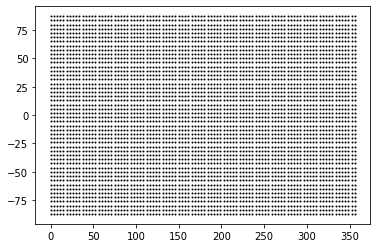

In [11]:
X_speedy_lon = np.linspace(0,360-3.75,96)
Y_speedy_lat = np.array("-87.159 -83.479 -79.777 -76.070 -72.362 -68.652 -64.942 -61.232 -57.521 -53.810 -50.099 -46.389 -42.678 -38.967 -35.256 -31.545 -27.833 -24.122 -20.411 -16.700 -12.989 -9.278 -5.567 -1.856 1.856 5.567 9.278 12.989 16.700 20.411 24.122 27.833 31.545 35.256 38.967 42.678 46.389 50.099 53.810 57.521 61.232 64.942 68.652 72.362 76.070 79.777 83.479 87.159".split(" "))
Y_speedy_lat = Y_speedy_lat.astype(np.float32)

def plot_speedy():
    plt.figure()
    for x in X_speedy_lon:
        for y in Y_speedy_lat:
            plt.plot(x,y,'ko',ms=1);

plot_speedy()

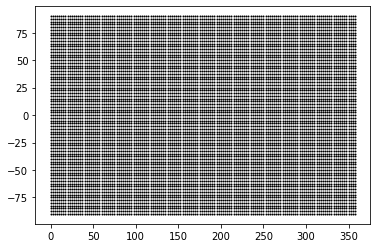

In [12]:
## NOAA latitude goes from North To South
X_noaa_lon = np.linspace(0,360-2.5,144)
Y_noaa_lat = np.linspace(90,-90,73)

def plot_noaa():
    plt.figure()
    for x in X_noaa_lon:
        for y in Y_noaa_lat:
            plt.plot(x,y,'ko',ms=1);

plot_noaa()

In [13]:
PRESSURE_LEVELS_HEIGHTS_VALUES = [
    762,
    1458,
    3013,
    5576,
    9166,
    11787,
    16000,
]

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)

def wind_comps(obs):
    # ESE at 11 knots
    # WSW at greater than 99 knots
    if 'knots' in obs and 'variable' not in obs:
        compass_point, mag = re.findall(r".*wind:\s(\w+).*([0-9]+)[\s]knots", obs)[0]
        ang = portolan.middle(compass_point)
        mag = int(mag) / 1.944
        u = mag * np.sin(ang)
        v = mag * np.cos(ang)
        return (u, v)
    else:
        return (0, 0)


def month2number(month_name):
    datetime_object = datetime.datetime.strptime(month_name, '%b')
    return datetime_object.month


def parse_datetime(time):
    return datetime.datetime.strptime(time, '%a %b %d %H:%M:%S %Y')

def elev_to_press_level(elev):
    max_diff = 10000
    level = 0
    for (idx, val) in enumerate(PRESSURE_LEVELS_HEIGHTS_VALUES):
        diff = abs(val - elev)
        if max_diff > diff:
            level = idx
            max_diff = diff
    return level

def calculate_spec_humidity(dew_point, pressure):
    e0 = 6.113 # saturation vapor pressure in hPa",
    # e0 and Pressure have to be in same units",
    c = 5423 # L/R for water in Kelvin",
    T0 = 273.15 # Kelvin\n",    #calculating specific humidity, q directly from dew point temperature",
    #using equation 4.24, Pg 96 Practical Meteorolgy (Roland Stull)",
    q = (622 * e0 * np.exp(c * (dew_point - T0)/(dew_point * T0)))/pressure # g/kg",
    return q/1000
def calculate_rela_humidity(dew_point,temperature):
    c=243.04
    b=17.625
    rhum=100 * np.exp((c *b *(dew_point - temperature))/((c + dew_point)*(c + temperature)))
    return rhum
def parse_pressure(obs):
    # pressure: 1027.8 mb
    # 3-hr pressure change 1.7hPa, increasing, then decreasing
    press = 0.0
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0])
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0])
    # hPa
    return press

In [14]:
idx = 97800
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)
print(row['lat'], row['lng'], row['elev'])
elev_to_press_level(int(row['elev']))

station: KSAN
type: routine report, cycle 13 (automatic report)
time: Wed Oct 14 12:51:00 2020
temperature: 20.6 C
dew point: 16.7 C
wind: calm
visibility: 10 miles
pressure: 1011.5 mb
sky: a few clouds at 25000 feet
- AO2SLP115
METAR: KSAN 141251Z 00000KT 10SM FEW250 21/17 A2987 RMK AO2SLP115 T02060167
32.733333333333334 -117.18333333333334 12


0

In [15]:
df['datetime'] = pd.to_datetime(df.datetime)
df = df.sort_values(by='datetime')

df.head()

,lat,lng,elev,datetime,observation
1339919,46.783333,23.683333,413,2020-08-01,LRCL 010000Z 28006KT CAVOK 19/15 Q1014
1439630,24.133333,38.066667,8,2020-08-01,OEYN 010000Z 18010KT 9999 BKN040 33/29 Q0999 N...
1212342,39.866667,4.216667,82,2020-08-01,LEMH 010000Z AUTO 11004KT 9999 4300 FEW003/// ...
1033168,-33.633333,-71.616667,75,2020-08-01,SCSN 010000Z AUTO VRB02KT CAVOK 10/10 Q1012
1439392,26.183333,36.466667,16,2020-08-01,OEWJ 010000Z 12004KT CAVOK 30/28 Q1000 NOSIG


In [16]:
def parse_metars(idx):
    dt = []
    cords = []
    row = df.iloc[idx]
    try:
        temp=0
        obs = Metar.Metar(row['observation']).string()
        if ('temperature' in obs):
            temp = float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0])+ 273.15 
            if temp<331.15:
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'air', temp])
            else:
                temp=0

        (u, v) = wind_comps(obs)
        if (u, v) != (0,0):
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'uwnd', u])
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'vwnd', v])

        # pA
        if ('pressure' in obs):
            press = parse_pressure(obs)
            if press < 1051 and press > 522:
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'press', press])

        if ('dew point' in obs and 'pressure' in obs):
            dew_point = float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0])+273.15 
            if dew_point > 0 and press < 1050 and press > 522 and dew_point <= temp and temp != 0 :
                shum = calculate_spec_humidity(dew_point, press)
                rhum = calculate_rela_humidity(dew_point, temp)
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'rhum', rhum])
                if shum < 0.05:
                    dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'shum', shum])

        cords.append((row['lat'], row['lng']))
    except Exception as e:
        str_err = str(e)
        if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
            print('index:', idx, 'error:', e)
    return (dt, cords)

In [17]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(parse_metars, range(len(df)))

In [18]:
df_parsed_metars = []
active_stations = []

for elem in data:
    df_parsed_metars += elem[0]
    for cords in elem[1]:
        if (cords not in active_stations):
            active_stations.append(cords)

In [19]:
print(len(df_parsed_metars))

3025035


In [20]:
len(active_stations)

5002

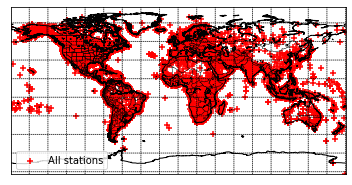

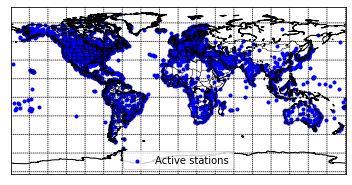

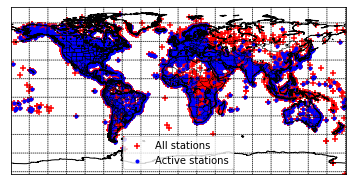

In [21]:
lati = []
lngt = []
lati2 = []
lngt2 = []
dataexport=[]
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    lati.append(gms_to_lat_lng(lat))
    lngt.append(gms_to_lat_lng(lng))
    nombreEstacion=station['ICAO']
    dataexport.append([nombreEstacion,gms_to_lat_lng(lat),gms_to_lat_lng(lng),elev])

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('all_stations.jpg', dpi=600)
plt.show()

for station in active_stations:
    row = df.iloc[idx]
    lati2.append(station[0])
    lngt2.append(station[1])
    
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('active_stations.jpg', dpi=600)
plt.show()

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('all_stations_vs_active_stations.jpg', dpi=600)
plt.show()

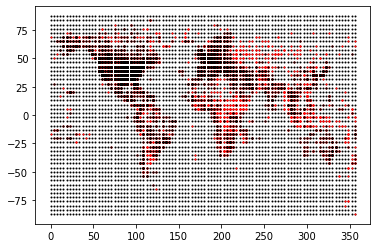

In [22]:
plot_speedy()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in active_stations:
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


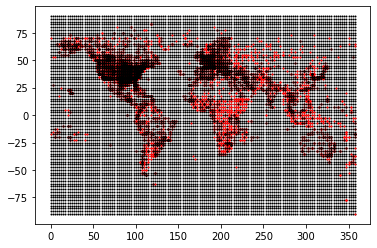

In [23]:
plot_noaa()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in active_stations:
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


In [24]:
df_metar_info = pd.DataFrame(df_parsed_metars,columns=['datetime','lat','lng','elev','variable','value'])

df_metar_info.head(10)

,datetime,lat,lng,elev,variable,value
0,2020-08-01 00:00:00,46.783333,23.683333,413,air,292.150000
1,2020-08-01 00:00:00,46.783333,23.683333,413,uwnd,-0.543352
2,2020-08-01 00:00:00,46.783333,23.683333,413,vwnd,3.038216
3,2020-08-01 00:00:00,46.783333,23.683333,413,press,1014.000000
4,2020-08-01 00:00:00,46.783333,23.683333,413,rhum,94.150927
5,2020-08-01 00:00:00,46.783333,23.683333,413,shum,0.010540
6,2020-08-01 00:00:00,24.133333,38.066667,8,air,306.150000
7,2020-08-01 00:00:00,24.133333,38.066667,8,press,999.000000
8,2020-08-01 00:00:00,24.133333,38.066667,8,rhum,94.438024
9,2020-08-01 00:00:00,24.133333,38.066667,8,shum,0.025588


In [25]:
df_metar_info.tail()

,datetime,lat,lng,elev,variable,value
3025030,2020-09-30 12:59:00,30.466667,-86.516667,26,uwnd,0.000000
3025031,2020-09-30 12:59:00,30.466667,-86.516667,26,vwnd,2.572016
3025032,2020-09-30 12:59:00,30.466667,-86.516667,26,press,1019.300000
3025033,2020-09-30 12:59:00,30.466667,-86.516667,26,rhum,94.064856
3025034,2020-09-30 12:59:00,30.466667,-86.516667,26,shum,0.008045


In [26]:
all_df_datetimes = []

for df_datetime in df_metar_info.datetime.unique():
    parsed_datetime = datetime.datetime.strptime(df_datetime, '%Y-%m-%d %H:%M:%S')
    if parsed_datetime.minute == 0:
        all_df_datetimes.append(parsed_datetime)

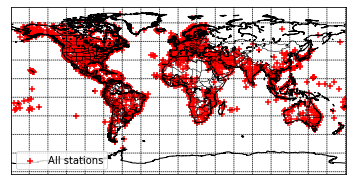

In [28]:
Show_df=df_metar_info.loc[df_metar_info['variable']=='shum'].loc[df_metar_info['value']<50]
lataux=[]
lngaux=[]
for reg in Show_df.values:
    if reg[1] not in lataux and reg[2] not in lngaux:
        lataux.append(reg[1])
        lngaux.append(reg[2])
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngaux,
    lataux,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('all_stations.jpg', dpi=600)
plt.show()


In [29]:
df_metar_info.loc[df_metar_info['variable']=='shum'].loc[df_metar_info['value']<50]['value'].describe()

count    545554.000000
mean          0.010721
std           0.004820
min           0.000123
25%           0.007050
50%           0.009852
75%           0.013692
max           0.034478
Name: value, dtype: float64

In [30]:
def create_csv(file_datetime):
    filename = "data/{}.csv".format(file_datetime.strftime('%Y%m%d%H'))
    df_file = df_metar_info.loc[df_metar_info['datetime'].str.contains(file_datetime.strftime('%Y-%m-%d %H'))]
    df_file.to_csv(filename, index=False)

In [31]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(create_csv, all_df_datetimes)